In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from torchvision.transforms import ToTensor, Compose
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torchviz import make_dot
from tqdm.notebook import tqdm

In [9]:
train_dataset = MNIST(download=True, root='data', train=True, transform=ToTensor())
train_data = DataLoader(train_dataset, batch_size=64, shuffle=False)

test_dataset = MNIST(download=True, root='data', train=False, transform=ToTensor())
test_data = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
class AutoEncoder(nn.Module):
    def __init__(self, in_features, hidden_features):
      super(AutoEncoder, self).__init__()
      self.encoder = nn.Sequential(
        nn.Linear(in_features, hidden_features),
        nn.ReLU()
      )

      self.decoder = nn.Sequential(
        nn.Linear(hidden_features, in_features),
        nn.ReLU()
      )

    def bottom_up(self, x):
      return self.encoder(x)
    
    def top_down(self, x):
      return self.decoder(x)

In [12]:
criterion = nn.MSELoss()

In [13]:
layers = [
  AutoEncoder(784, 256),
  AutoEncoder(256, 128),
  AutoEncoder(128, 64)
]

In [14]:

for image, labels in train_data:
  image, labels = image.to(device), labels.to(device)

  image = image.flatten(start_dim=1)
  activation = image

  bottom_up_activations = [activation] # How were the layers activated from bottom up?
  top_down_activations = [] # How were the layers activated from top down?

  for layer in layers:
    activation = layer.bottom_up(activation)
    bottom_up_activations.append(activation.clone())

  for layer in layers[::-1]: # Reverse the list
    activation = layer.top_down(activation)
    top_down_activations.append(activation.clone())
  
  top_down_activations.reverse()

  for (bottom_up_activation, top_down_activation) in zip(bottom_up_activations, top_down_activations):
    loss = criterion(top_down_activation, bottom_up_activation)
    loss.backward()

    break
    print(top_down_activation.shape, layers[0].encoder[0].weight.grad.norm())
  
  break

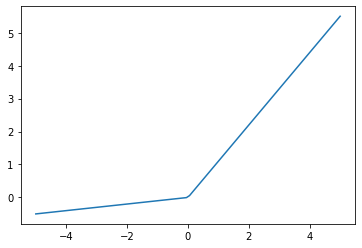

NameError: name 'W1' is not defined

In [15]:
import numpy as np

def relu(x, deriv=False):
  if deriv:
    return 1.0 * (x > 0)
  return x * (x > 0)


def sigmoid(x, deriv=False):
  out = 1.0 / (1.0 + np.exp(-x))
  if deriv:
    return out * (1 - out)
  return out

def leaky_relu(x, deriv=False):
  factor = ((x > 0) + 0.1)
  if deriv:
    return factor
  return factor * x




xs = np.linspace(-5, 5, 100)
ys = leaky_relu(xs)
plt.plot(xs, ys)
plt.show()

activation = leaky_relu

in_features = 28*28
out_features = 512

# He initialization?


image = next(iter(train_data))[0]
x = image.flatten(start_dim=1).numpy()

z1 = x @ W1.T
a1 = activation(z1)
z2 = a1 @ W2.T
a2 = activation(z2)

plt.title("Original image")
plt.imshow(x[0].reshape((28, 28)))
plt.show()

plt.title("Before training")
plt.imshow(a2[0].reshape((28, 28)))
plt.show()

loss_history = []

for i in range(5000):
  # Forward pass
  z1 = x @ W1.T
  a1 = activation(z1)
  z2 = a1 @ W2.T
  a2 = activation(z2)

  # Calculate loss
  loss = (0.5 * (a2 - x)**2).mean()
  loss_history.append(loss)

  # Backward pass
  dEda2 = a2 - x
  da2dz2 = activation(z2, deriv=True)
  dz2dW2 = a1
  da2dW2 = da2dz2[:, :, None] @ dz2dW2[:, None, :]
  dEdW2 = (da2dW2.T * dEda2.T).T

  # Gradient step
  W2 -= 1e-3 * dEdW2.mean(axis=0)

plt.plot(loss_history)
plt.show()


In [16]:
class PredLayer:
  def __init__(self, in_features, out_features, activation=leaky_relu, lr=1e-3):
    self.W1 = (np.random.random((out_features, in_features)) * 2 - 1) * 2/np.sqrt(in_features) 
    self.W2 = (np.random.random((in_features, out_features)) * 2 - 1) * 2/np.sqrt(in_features) 
    self.b1 = np.zeros(out_features)
    self.b2 = np.zeros(in_features)
    self.activation = activation
    self.lr = lr
  
  def down(self, r):
    return self.activation(r @ self.W2.T + self.b2)

  def up(self, x, r):
    # Down inhibits inputs.
    return self.activation((x - self.down(r)) @ self.W1.T + self.b1)

  def learn_down(self, x, r):
    z = r @ self.W2.T + self.b2
    a = self.activation(z)

    dEda = a - x
    dadz = self.activation(z, deriv=True)
    dzdW = r
    dadW = dadz[:, :, None] @ dzdW[:, None, :]
    dEdW = (dadW.T * dEda.T).T
    dEdb = dEda * dadz

    # Gradient step
    self.W2 -= self.lr * dEdW.mean(axis=0)
    self.b2 -= self.lr * dEdb.mean(axis=0)
    return ((a - x) ** 2).mean()

  def learn_up(self, x, r, r_t):
    x_i = x - self.down(r)
    z = x_i @ self.W1.T + self.b1
    a = self.activation(z)

    dEda = a - r_t
    dadz = self.activation(z, deriv=True)
    dzdW = x_i
    dadW = dadz[:, :, None] @ dzdW[:, None, :]
    dEdW = (dadW.T * dEda.T).T
    dEdb = dEda * dadz

    # Gradient step
    self.W1 -= self.lr * dEdW.mean(axis=0)
    self.b1 -= self.lr * dEdb.mean(axis=0)
    return ((a - r_t) ** 2).mean()

# Identity layer
class StopLayer:
  def down(self, r):
    return r

  def up(self, x):
    return x


In [17]:
def onehot(x):
  return np.eye(10)[x]

In [18]:
layer1 = PredLayer(784, 256)
layer2 = PredLayer(256, 128)
layer3 = PredLayer(128, 64)
layer4 = PredLayer(64, 10)
r1 = np.zeros((1, 256))
r2 = np.zeros((1, 128))
r3 = np.zeros((1, 64))
losses = []

In [19]:
for epoch in range(5):
  print(f"Epoch: {epoch}")
  for images, labels in tqdm(train_data):
    x = images.flatten(start_dim=1).numpy()
    #y = onehot(labels.numpy())
    r1_u = layer1.up(x, r1)
    r2_u = layer2.up(r1_u, r2)
    r3_u = layer3.up(r2_u, r3)
    #r4_u = layer4.up(r3_u, r4)

    #r3_d = layer4.down(r4_u)
    r2_d = layer3.down(r3_u)
    r1_d = layer2.down(r2_d)
    x_hat = layer1.down(r1_d)

    # Maybe do stuff here in order to learn up transformation?
    r1_u2 = layer1.up(x_hat, r1_u)
    r2_u2 = layer2.up(r1_u, r2_u)
    #r3_u2 = layer3.up(r2_u, r3_u)

    # Update weights here
    loss_down_1   = layer1.learn_down(x, r1_u)
    loss_up_1     = layer1.learn_up(x_hat, r1_u, np.zeros_like(r1_u))

    loss_down_2   = layer2.learn_down(r1_u, r2_u)
    loss_up_2     = layer2.learn_up(r1_u2, r2_u, np.zeros_like(r2_u))

    loss_down_3   = layer3.learn_down(r2_u, r3_u)
    loss_up_3     = layer3.learn_up(r2_u, r3_u, np.zeros_like(r3_u))

    loss_down_4   = 0 #layer4.learn_down(r3_u, r4_u)
    loss_up_4     = 0 #layer4.learn_up(r3_u, r4_u, y)

    losses.append((loss_down_1, loss_up_1, loss_down_2, loss_up_2, loss_down_3, loss_up_3, loss_down_4, loss_up_4))

losses_down_1, losses_up_1, losses_down_2, losses_up_2, losses_down_3, losses_up_3, losses_down_4, losses_up_4 = zip(*losses)
plt.plot(losses_down_1)
plt.show()

plt.plot(losses_up_1)
plt.show()

plt.plot(losses_down_2)
plt.show()

plt.plot(losses_up_2)
plt.show()

plt.plot(losses_down_3)
plt.show()

plt.plot(losses_up_3)
plt.show()

plt.plot(losses_down_4)
plt.show()

plt.plot(losses_up_4)
plt.show()

Epoch: 0


  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
image = next(iter(test_data))[0]
x = image.flatten(start_dim=1).numpy()
r1_u = layer1.up(x, r1)
r2_u = layer2.up(r1_u, r2)
r3_u = layer3.up(r2_u, r3)

r2_d = layer3.down(r3_u)
r1_d = layer2.down(r2_d)
x_hat = layer1.down(r1_d)

plt.imshow(x.mean(axis=0).reshape(28, 28))
plt.show()

for i in range(10):
  fig, axs = plt.subplots(1, 2)
  axs[0].imshow(x[i].reshape((28, 28)))
  axs[1].imshow(x_hat[i].reshape((28, 28)))
  plt.show()

plt.show()

In [281]:
layer1 = PredLayer(784, 256)
layer2 = PredLayer(256, 128)
layer3 = PredLayer(128, 64)
layer4 = PredLayer(64, 10)
r1 = np.zeros((1, 256))
r2 = np.zeros((1, 128))
r3 = np.zeros((1, 64))
losses = []

In [269]:
losses = []
for epoch in range(1):
  print(f"Epoch: {epoch}")
  for images, labels in tqdm(train_data):
    x = images.flatten(start_dim=1).numpy()
    #y = onehot(labels.numpy())
    r1_u = layer1.up(x, r1)
    r2_u = layer2.up(r1_u, r2)

    r1_d = layer2.down(r2_u)
    x_hat = layer1.down(r1_d)

    r1_u2 = layer1.up(x_hat, r1)

    # Update weights here
    loss_down_1   = layer1.learn_down(x, r1_u)
    loss_up_1     = layer1.learn_up(x_hat, r1, r1_u)

    loss_down_2   = layer2.learn_down(r1_u, r2_u)
    loss_up_2     = layer2.learn_up(r1_u2, r2, r2_u)

    losses.append((loss_down_1, loss_up_1, loss_down_2, loss_up_2))

losses_down_1, losses_up_1, losses_down_2, losses_up_2 = zip(*losses)
plt.plot(losses_down_1)
plt.show()

plt.plot(losses_up_1)
plt.show()

plt.plot(losses_down_2)
plt.show()

plt.plot(losses_up_2)
plt.show()

Epoch: 0


  0%|          | 0/938 [00:00<?, ?it/s]

TypeError: 'numpy.float64' object is not iterable

Loss: 0.33158813716029284


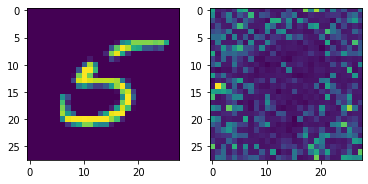

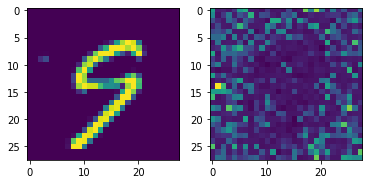

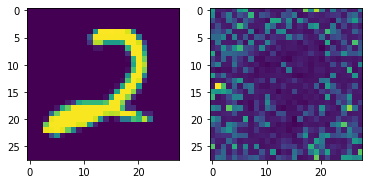

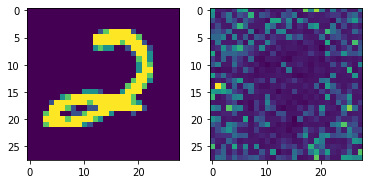

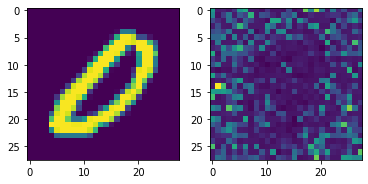

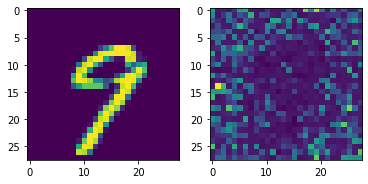

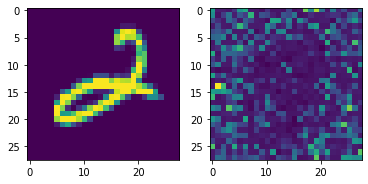

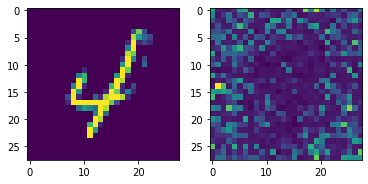

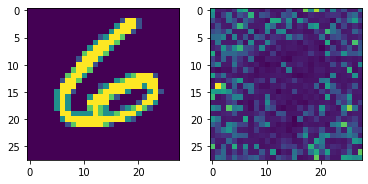

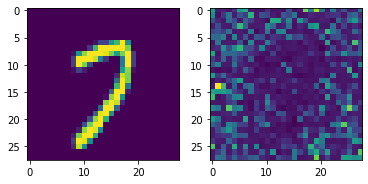

In [268]:
losses = []
for image, label in test_data:
  r1_u = layer1.up(x, r1)
  r2_u = layer2.up(r1_u, r2)
  r1_d = layer2.down(r2_u)
  x_hat = layer1.down(r1_d)
  
  loss = ((x - x_hat) ** 2).mean()
  losses.append(loss)

loss = np.mean(losses)
print(f"Loss: {loss}")

for i in range(10):
  fig, axs = plt.subplots(1, 2)
  axs[0].imshow(x[i].reshape((28, 28)))
  axs[1].imshow(x_hat[i].reshape((28, 28)))
  plt.show()

plt.show()

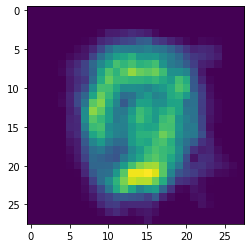

Loss: 0.045903107600398785


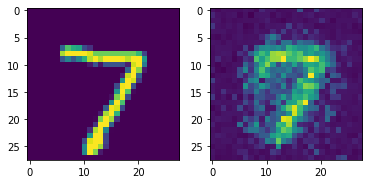

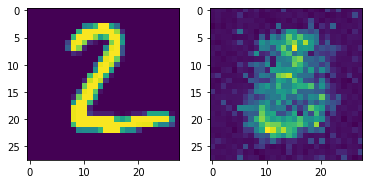

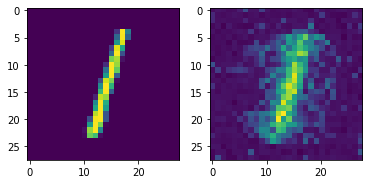

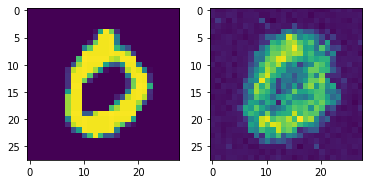

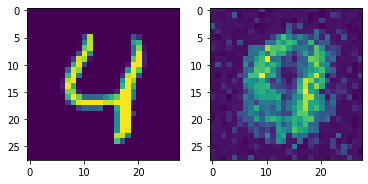

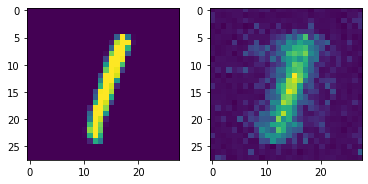

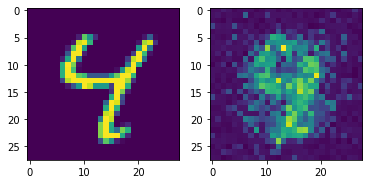

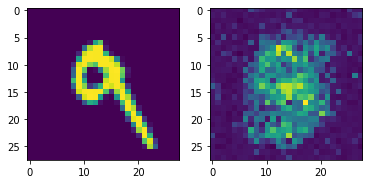

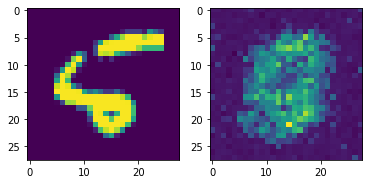

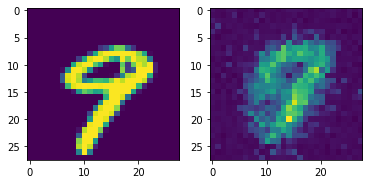

In [197]:
image = next(iter(test_data))[0]
x = image.flatten(start_dim=1).numpy()
r1_u = layer1.up(x, r1)
r2_u = layer2.up(x, r1_u)
r1_d = layer1.down(r2_u)
x_hat = layer1.down(r1_d)

plt.imshow(x.mean(axis=0).reshape(28, 28))
plt.show()

losses = []
for image, label in test_data:
  r1_u = layer1.up(x, r1)
  r2_u = layer2.up(x, r1_u)
  r1_d = layer1.down(r2_u)
  x_hat = layer1.down(r1_d)
  
  loss = ((x - x_hat) ** 2).mean()
  losses.append(loss)

loss = np.mean(losses)
print(f"Loss: {loss}")

for i in range(10):
  fig, axs = plt.subplots(1, 2)
  axs[0].imshow(x[i].reshape((28, 28)))
  axs[1].imshow(x_hat[i].reshape((28, 28)))
  plt.show()

plt.show()

In [285]:
# Recirculation algorithm
activation = leaky_relu
lr = 1e-3
in_features = 784
out_features = 256

w1 = (np.random.random((out_features, in_features)) * 2 - 1) * 2/np.sqrt(in_features) 
b1 = np.zeros(out_features)

w2 = (np.random.random((in_features, out_features)) * 2 - 1) * 2/np.sqrt(out_features) 
b2 = np.zeros(in_features)

loss_history = []

  0%|          | 0/938 [00:00<?, ?it/s]

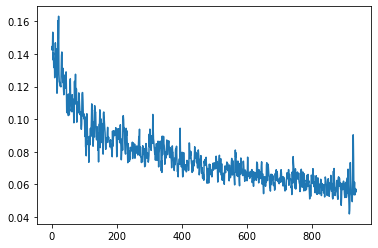

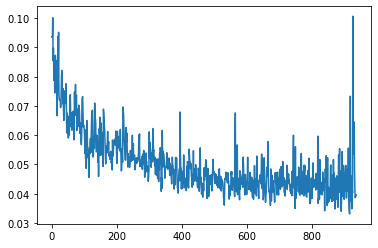

In [286]:
for epoch in range(1):
  for images, labels in tqdm(train_data):
    x = images.flatten(start_dim=1).numpy()

    z1 = x @ w1.T + b1
    a1 = activation(z1)
    z2 = a1 @ w2.T + b2
    a2 = activation(z2)

    x_pred = a2

    x2 = x_pred # Could this be views as inhibition?
    z3 = x2 @ w1.T + b1
    a3 = activation(z3)

    loss1 = ((x - x_pred) ** 2).mean()
    loss2 = ((a3 - a1) ** 2).mean()

    # Train up weights
    dEda3 = a3 - a1
    da3dz3 = activation(z3, deriv=True)
    dz3dW3 = x2
    da3dW1 = da3dz3[:, :, None] @ dz3dW3[:, None, :]
    dEdW1 = (da3dW1.T * dEda3.T).T
    dEdb1 = dEda3 * da3dz3

    # Train down weights
    dEda2 = x_pred - x
    da2dz2 = activation(z2, deriv=True)
    dz2dW2 = a1
    da2dW2 = da2dz2[:, :, None] @ dz2dW2[:, None, :]
    dEdW2 = (da2dW2.T * dEda2.T).T
    dEdb2 = dEda2 * da2dz2

    # Take gradient step
    w1 -= lr * dEdW1.mean(axis=0)
    b1 -= lr * dEdb1.mean(axis=0)
    w2 -= lr * dEdW2.mean(axis=0) 
    b2 -= lr * dEdb2.mean(axis=0)

    loss_history.append((loss1, loss2))
  
losses1, losses2 = zip(*loss_history)

plt.plot(losses1)
plt.show()

plt.plot(losses2)
plt.show()


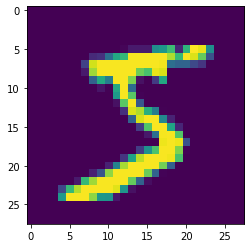

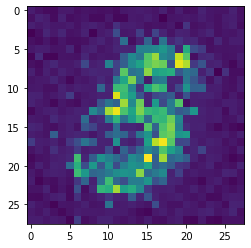

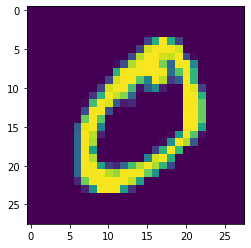

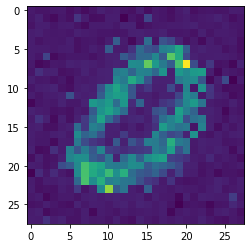

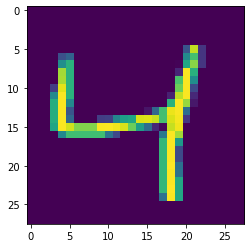

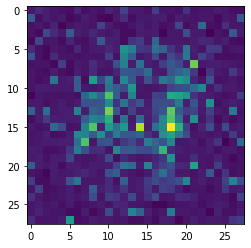

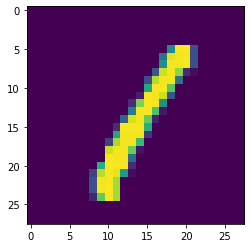

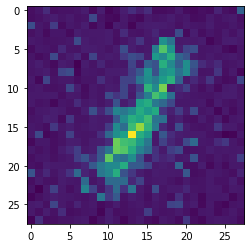

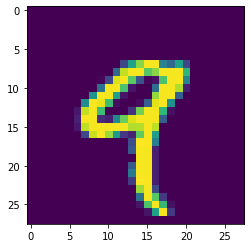

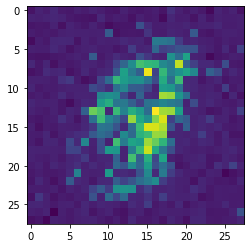

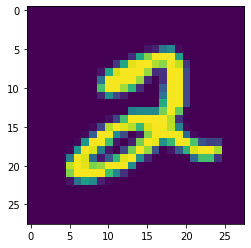

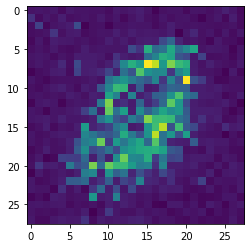

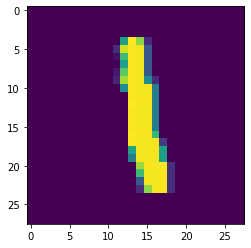

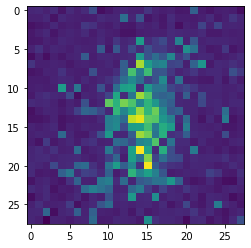

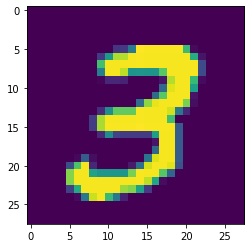

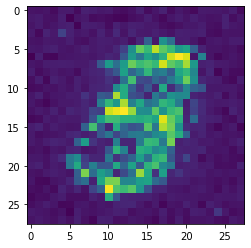

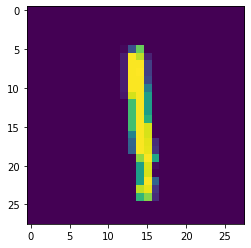

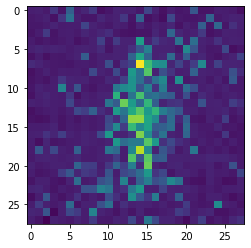

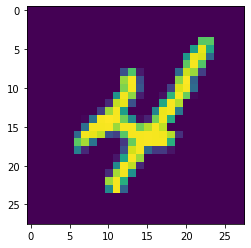

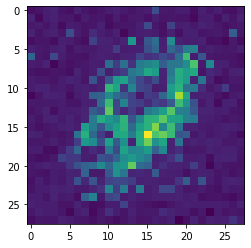

In [287]:
for images, labels in train_data:
  x = images.flatten(start_dim=1).numpy()

  for i in range(10):
    z1 = x @ w1.T + b1
    a1 = activation(z1)
    z2 = a1 @ w2.T + b2
    x_pred = activation(z2)

    plt.imshow(x[i].reshape(28, 28))
    plt.show()

    plt.imshow(x_pred[i].reshape(28, 28))
    plt.show()

  break

Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5


  0%|          | 0/938 [00:00<?, ?it/s]

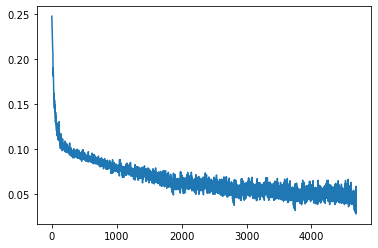

In [244]:
from itertools import islice
ir = 1 # Inference rate
lr = 1e-2 # Learning rate

def get_weights_and_biases(in_features, out_features):
  w = (np.random.random((out_features, in_features)) * 2 - 1) * 1/np.sqrt(in_features)
  b = np.zeros(out_features)

  return w, b

# Define out layer sizes
in_features = 784
hidden_features = 256
out_features = 10

# Define weights and biases
W1, b1 = get_weights_and_biases(in_features, hidden_features)
W2, b2 = get_weights_and_biases(hidden_features, out_features)

loss_history = []
activation1 = leaky_relu
activation2 = sigmoid

for epoch in range(5):
  print(f"Epoch {epoch+1}")
  tqdm_train_data = tqdm(train_data)
  for images, labels in tqdm_train_data:
    x0 = images.flatten(start_dim=1).numpy()
    x1 = np.zeros((x0.shape[0], hidden_features))
    x2 = np.zeros((x0.shape[0], out_features))
    x3 = onehot(labels) # Constrain output to be the correct labels.

    x3_pred = activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2)

    loss = ((x3 - x3_pred) ** 2).mean() # MSE loss
    tqdm_train_data.set_description(f"Loss: {loss}")
    loss_history.append(loss)
    errors_history = []

    # Run predictive coding inference. 
    for t in range(10):
      u1 = x0 @ W1.T + b1
      u2 = activation1(x1) @ W2.T + b2
      u3 = activation2(x2)

      # Calculate errors
      e1 = x1 - u1
      e2 = x2 - u2
      e3 = x3 - u3

      # Canculate derivatives
      dx1 = -e1 + activation1(x1, deriv=True) * (e2 @ W2)
      dx2 = -e2 + activation2(x2, deriv=True) * e3
      #dx3 = -e3 # Only do this during inference

      # Do actual steps
      x1 += ir * dx1
      x2 += ir * dx2
      #x3 -= ir * dx3 # Only do this during inference.

    error_histories = zip(*errors_history)
    for error_history in error_histories:
      plt.plot(error_history)
      plt.show()
      
    # Perform weight update here.
    dW1 = e1[:, :, None] @ activation1(x0)[:, None, :]
    dW2 = e2[:, :, None] @ activation2(x1)[:, None, :]

    W1 += lr * dW1.mean(axis=0)
    W2 += lr * dW2.mean(axis=0)

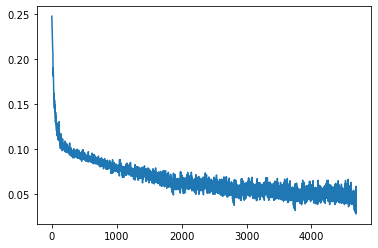

In [245]:
plt.plot(loss_history)
plt.show()

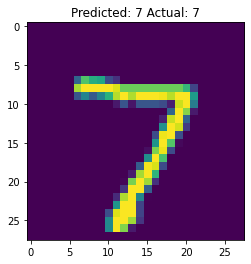

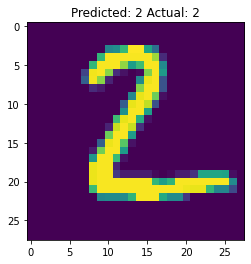

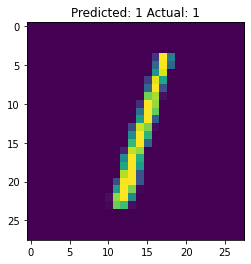

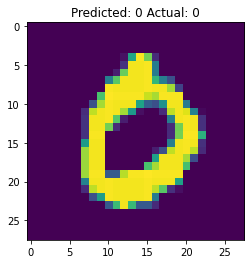

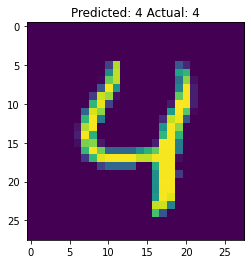

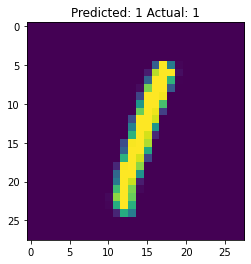

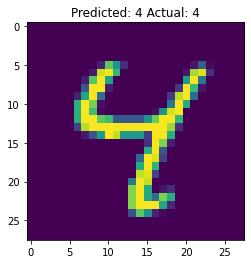

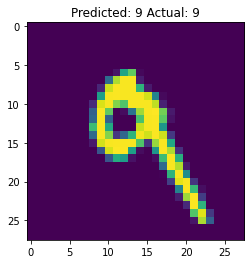

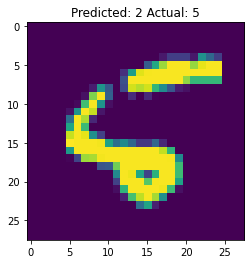

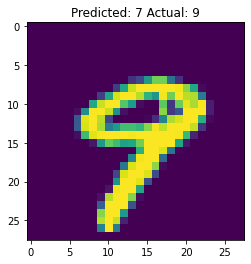

In [251]:
for images, labels in test_data:
  x0 = images.flatten(start_dim=1).numpy()
  x3_pred = activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2)
  pred_labels = np.argmax(x3_pred, axis=1)

  for i in range(10):
    plt.title(f"Predicted: {pred_labels[i]} Actual: {labels[i]}")
    plt.imshow(images[i].reshape(28, 28))
    plt.show()

  break